# Argo / GO-SHIP Comparison

This will serve as our working notebook, broken into our discussed working components below. 

## This cell for imports, constants

In [1]:
# data processing
import numpy as np
import pandas as pd
import xarray as xr
from time import sleep

# data visualization
%matplotlib inline
import matplotlib.pyplot as plt
%matplotlib inline

# API convenience functions
from utilities_NSF_EC2022 import get_data_for_timeRange

# geographic functions
import cartopy.crs as ccrs
import cartopy.feature as cft
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import warnings
warnings.filterwarnings('ignore')

# set constants
URL_PREFIX = 'https://argovis-api.colorado.edu'
API_KEY = ''

## This cell for data loading/processing to xarray

In [5]:
# more convenient wrapper for if you want a line just by name
def get_goship_line(line_name, startDate='2000-01-01T00:00:00Z', endDate='2022-05-01T00:00:00Z', dt_tag='365d', url=URL_PREFIX, api_key=API_KEY):
    df = get_data_for_timeRange(startDate, endDate, url_prefix=url+'/profiles?', 
                                source='cchdo_go-ship', woceline=line_name, 
                                myAPIkey=api_key, dt_tag=dt_tag)
    return df

# I think we should have a time independent version of this function as well
# could cheat this function into doing it with something like timedelta=1e5 or something
def get_argo_along_line(time, coords, radius=50, timedelta=30, dt_tag='365d', url=URL_PREFIX, api_key=API_KEY):
    df_all = pd.DataFrame()
    for t, c in zip(time, coords):
        sleep(.2)
        startDate = (pd.Timestamp(t) - pd.Timedelta(timedelta/2)).strftime('%Y-%m-%dT%H:%M:%SZ')
        endDate   = (pd.Timestamp(t) + pd.Timedelta(timedelta/2)).strftime('%Y-%m-%dT%H:%M:%SZ')
        center    = f'{c[0]},{c[1]}'
        df = get_data_for_timeRange(startDate, endDate, url_prefix=url+'/profiles?',
            center=center, radius_km=f'{radius}', source='argo_core', data='pres,temp,psal',
            myAPIkey=api_key, dt_tag=dt_tag, writeFlag=False)
        df_all = df_all.append(df)
    
    return df_all

# get argo data along line A22
a22 = get_goship_line('A22')
coords = [c['coordinates'] for c in a22.geolocation]
time = a22.timestamp.values
argo_a22 = get_argo_along_line(time, coords)

In [6]:
# process data from full of JSON points to more usable form
def json_dataframe_to_dataframe(df):
    out = pd.DataFrame()
    for i in range(df.shape[0]):
        # get the argo data
        data_dict = dict()
        data = df.data.iloc[i]
        # repeat location and time data for same lenth as array
        N_levels = len(data)
        data_dict['wmo'] = N_levels*[int(df._id.iloc[i].split('_')[0])]
        data_dict['cycle_number'] = N_levels*[df.cycle_number.iloc[i]]
        data_dict['time'] = N_levels*[df.timestamp.iloc[i]]
        data_dict['longitude'] = N_levels*[df.geolocation.iloc[i]['coordinates'][0]]
        data_dict['latitude'] = N_levels*[df.geolocation.iloc[i]['coordinates'][1]]
        # extract data from JSON dict
        for k in df.data_keys.iloc[i]:
            data_dict[k] = [d[k] for d in data]

        out = pd.concat((out, pd.DataFrame(data_dict, index=(i+1)*np.ones((N_levels,), dtype=int))))
    
    return out

df = json_dataframe_to_dataframe(argo_a22)

def dataframe_to_xarray(df):
    # get max number of depth levels
    ix = df.index.unique()
    number_profiles = ix.shape[0]
    max_levels = -np.inf
    for nprof in ix:
        if df.loc[nprof].shape[0] > max_levels:
            max_levels = df.loc[nprof].shape[0]

    # extract lower dimension metadata
    metadata = ['wmo', 'cycle_number', 'time', 'longitude', 'latitude']
    meta_dict = dict()
    for k in metadata:
        meta_dict[k] = [df[k].loc[i].iloc[0] for i in ix]
    df = df.drop(metadata, axis=1)
    data_dict = {k:np.nan*np.ones((number_profiles, max_levels)) for k in df.columns}

    # put argo data into "square" arrays
    for nprof in ix:
        profile = df.loc[nprof]
        current_depth_levels = profile.shape[0]
        for k in profile.columns:
            data_dict[k][nprof-1,:current_depth_levels] = profile[k]
    

    # create xarray dataset
    ds = xr.Dataset(
        data_vars = {k:(['n_prof', 'n_level'], v) for k, v in data_dict.items()},
        coords = {k:(['n_prof'], v) for k, v in meta_dict.items()}
    )
    # transpose for simpler plotting
    ds = ds.transpose('n_level', 'n_prof')

    return ds

ds = dataframe_to_xarray(df)

## This cell for Data Visualization

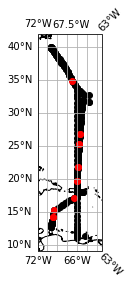

In [7]:
# figure out appropriate extent
coords = np.array(coords)
line_limits = [
    [np.min(coords[:,0]), np.max(coords[:,0])],
    [np.min(coords[:,1]), np.max(coords[:,1])]
]

# set up map
fig = plt.figure()
projection = ccrs.PlateCarree()
transform = ccrs.PlateCarree()
ax = fig.add_subplot(projection=projection)
ax.set_extent([line_limits[0][0]-2, line_limits[0][1]+2, line_limits[1][0]-2, line_limits[1][1]+2])
ax.add_feature(cft.GSHHSFeature('intermediate', edgecolor='black'))
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
gl = ax.gridlines(crs=transform, draw_labels=True)
gl.right_labels = False
gl.xformatter = lon_formatter
gl.yformatter = lat_formatter

# plot go-ship line coordinates
ax.plot(coords[:,0], coords[:,1], 'ko', transform=transform, label='GO-SHIP line A22')
# plot Argo coordinates
ax.plot(ds.longitude, ds.latitude, 'o', color='red', transform=transform, label='Core Argo Profiles')

In [8]:
# Turn mapping into a function

def create_map(coords, line_name):
    # figure out appropriate extent
    coords = np.array(coords)
    line_limits = [
        [np.min(coords[:,0]), np.max(coords[:,0])],
        [np.min(coords[:,1]), np.max(coords[:,1])]
    ]

    # set up map
    fig = plt.figure()
    projection = ccrs.PlateCarree()
    transform = ccrs.PlateCarree()
    ax = fig.add_subplot(projection=projection)
    ax.set_extent([line_limits[0][0]-2, line_limits[0][1]+2, line_limits[1][0]-2, line_limits[1][1]+2])
    ax.add_feature(cft.GSHHSFeature('intermediate', edgecolor='black'))
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    gl = ax.gridlines(crs=transform, draw_labels=True)
    gl.right_labels = False
    gl.xformatter = lon_formatter
    gl.yformatter = lat_formatter

    # plot go-ship line coordinates
    ax.plot(coords[:,0], coords[:,1], 'ko', transform=transform, label=line_name)
    # plot Argo coordinates
    ax.plot(ds.longitude, ds.latitude, 'o', color='red', transform=transform, label='Core Argo Profiles')

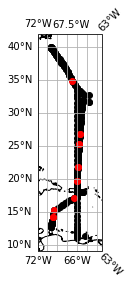

In [9]:
# Draw map with function
create_map(coords, "GO-SHIP Line A22")

## This cell for Data Interpolation/Comparison